In [1]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data 
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score
model_path = 'model/'
from function import get_tpr_fpr, save_tpr_fpr, load_tpr_fpr, evaluate
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.utils.data import Dataset

from torch_geometric.nn import GATConv, RGCNConv, GCNConv, global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, roc_auc_score

import rdkit
from rdkit.Chem.Scaffolds import MurckoScaffold

from itertools import compress
import random
from collections import defaultdict
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

from rdkit.Chem.Scaffolds import MurckoScaffold
from transformers import AutoModelWithLMHead, AutoTokenizer
import math
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
# from itertools import compress
# import random
# from collections import defaultdict
import pickle
device = 'cpu'
model_path = 'model/'

adj_max=80
fps_len=167
max_len=120

vocabulary = {'C': 1, 'c': 2, '1': 3, '(': 4, '-': 5, '2': 6, 's': 7, 'N': 8, '=': 9, ')': 10, 'n': 11, '[': 12,
                  '@': 13,
                  'H': 14, ']': 15, 'O': 16, 'S': 17, '3': 18, 'l': 19, 'B': 20, 'r': 21, '/': 22, '\\': 23, 'o': 24,
                  '4': 25,
                  '5': 26, '6': 27, '7': 28, '+': 29, '.': 30, 'I': 31, 'F': 32, '8': 33, '#': 34, 'P': 35, '9': 36,
                  'a': 37,
                  '%': 38, '0': 39, 'i': 40, 'e': 41, 'L': 42, 'K': 43, 't': 44, 'T': 45, 'A': 46, 'g': 47, 'Z': 48,
                  'M': 49,
                  'R': 50, 'p': 51, 'b': 52, 'X': 53}

known_drugs = ['O=C(NCCC(O)=O)C(C=C1)=CC=C1/N=N/C(C=C2C(O)=O)=CC=C2OCCOC3=CC=C(NC4=NC=C(C)C(NC5=CC=CC(S(NC(C)(C)C)(=O)=O)=C5)=N4)C=C3',
        'OCCOC1=CC=C(NC2=NC=C(C)C(NC3=CC=CC(S(NC(C)(C)C)(=O)=O)=C3)=N2)C=C1',
        'C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3',
        'CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N',
        'CCS(=O)(=O)N1CC(C1)(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3',
        'C1CC1C(=O)NC2=NN3C(=N2)C=CC=C3C4=CC=C(C=C4)CN5CCS(=O)(=O)CC5',
        'CCC1CN(CC1C2=CN=C3N2C4=C(NC=C4)N=C3)C(=O)NCC(F)(F)F',
        'OC(COC1=CC=C(NC2=NC=C(C)C(NC3=CC=CC(S(NC(C)(C)C)(=O)=O)=C3)=N2)C=C1)=O',
        'O=C(NCCC(O)=O)C(C=C1)=CC=C1/N=N/C(C=C2C(O)=O)=CC=C2OCCOC3=CC=C(NC4=NC=C(C)C(NC5=CC=CC(S(N)(=O)=O)=C5)=N4)C=C3',
        'OC1=CC=C(NC2=NC=C(C)C(NC3=CC=CC(S(NC(C)(C)C)(=O)=O)=C3)=N2)C=C1',
        'OCCOC1=CC=C(NC2=NC=C(C)C(NC3=CC=CC(S(N)(=O)=O)=C3)=N2)C=C1',
        'CC1=CN=C(N=C1NC2=CC(=CC=C2)S(=O)(=O)NC(C)(C)C)NC3=CC=C(C=C3)OCCN4CCCC4',
        'C1CCN(C1)CCOC2=C3COCC=CCOCC4=CC(=CC=C4)C5=NC(=NC=C5)NC(=C3)C=C2']

device = torch.device('cpu')
    
class jak_dataset(Dataset):
    def __init__(self, dataframe, max_len=80):
        super(jak_dataset, self).__init__()
        self.len = len(dataframe)
        self.dataframe = dataframe
        self.max_len = max_len
    def __getitem__(self, idx):
        y = 1 if self.dataframe.Activity[idx]==1 else 0
        X = torch.zeros(self.max_len)
        for idx, atom in enumerate(list(self.dataframe.Smiles[idx])[:self.max_len]):
            X[idx] = vocabulary[atom]
        
        return X.long(), y
    
    def __len__(self):
        return self.len
class encoder(nn.Module):
    def __init__(self, input_length, num_words, embedding_size=32, inner_size=32, output_size=fps_len, stride=1):
        super(encoder, self).__init__()

        self.input_length = input_length
        self.num_words = num_words
        self.embedding_size = embedding_size
        self.inner_size = inner_size
        self.output_size = output_size
        self.stride = stride

        self.embedding = nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0)

        self.conv_1 = nn.Conv1d(self.embedding_size, self.inner_size, 1, self.stride)
        self.conv_2 = nn.Conv1d(self.embedding_size, self.inner_size, 2, self.stride)
        self.conv_3 = nn.Conv1d(self.embedding_size, self.inner_size, 3, self.stride)

        self.w = nn.Linear(self.inner_size * 3, self.output_size)

        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.25)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.conv_1.weight)
        torch.nn.init.xavier_uniform_(self.conv_2.weight)
        torch.nn.init.xavier_uniform_(self.conv_3.weight)
        torch.nn.init.xavier_uniform_(self.w.weight)
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        tri = self.conv_3(x)
        bi = self.conv_2(x)
        uni = self.conv_1(x)

        tri_maxpool = nn.MaxPool1d(tri.shape[2])
        bi_maxpool = nn.MaxPool1d(bi.shape[2])
        uni_maxpool = nn.MaxPool1d(uni.shape[2])
        integrate_feat = torch.cat(
            (tri_maxpool(tri).squeeze(2), bi_maxpool(bi).squeeze(2), uni_maxpool(uni).squeeze(2)), dim=1)
        #print(integrate_feat.shape)
        return self.w(self.activation(integrate_feat))

def generate_scaffold(smiles, include_chirality=False):
    """
    Obtain Bemis-Murcko scaffold from smiles
    :param smiles:
    :param include_chirality:
    :return: smiles of scaffold
    """
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(
        smiles=smiles, includeChirality=include_chirality
    )
    return scaffold

def random_scaffold_split(
    dataset,
    smiles_list,
    task_idx=None,
    null_value=0,
    frac_train=0.8,
    frac_valid=0.1,
    frac_test=0.1,
    seed=42,
):
    """
    Adapted from https://github.com/pfnet-research/chainer-chemistry/blob/master/\
        chainer_chemistry/dataset/splitters/scaffold_splitter.py
    Split dataset by Bemis-Murcko scaffolds
    This function can also ignore examples containing null values for a
    selected task when splitting. Deterministic split
    :param dataset: pytorch geometric dataset obj
    :param smiles_list: list of smiles corresponding to the dataset obj
    :param task_idx: column idx of the data.y tensor. Will filter out
    examples with null value in specified task column of the data.y tensor
    prior to splitting. If None, then no filtering
    :param null_value: float that specifies null value in data.y to filter if
    task_idx is provided
    :param frac_train:
    :param frac_valid:
    :param frac_test:
    :param seed;
    :return: train, valid, test slices of the input dataset obj
    """

    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.0)

    if task_idx is not None:
        # filter based on null values in task_idx
        # get task array
        y_task = np.array([data.y[task_idx].item() for data in dataset])
        # boolean array that correspond to non null values
        non_null = y_task != null_value
        smiles_list = list(compress(enumerate(smiles_list), non_null))
    else:
        non_null = np.ones(len(dataset)) == 1
        smiles_list = list(compress(enumerate(smiles_list), non_null))

    rng = np.random.RandomState(seed)

    scaffolds = defaultdict(list)
    for ind, smiles in smiles_list:
        scaffold = generate_scaffold(smiles, include_chirality=True)
        scaffolds[scaffold].append(ind)

    scaffold_sets = rng.permutation(list(scaffolds.values()))

    n_total_valid = int(np.floor(frac_valid * len(dataset)))
    n_total_test = int(np.floor(frac_test * len(dataset)))

    train_idx = []
    valid_idx = []
    test_idx = []

    for scaffold_set in scaffold_sets:
        if len(valid_idx) + len(scaffold_set) <= n_total_valid:
            valid_idx.extend(scaffold_set)
        elif len(test_idx) + len(scaffold_set) <= n_total_test:
            test_idx.extend(scaffold_set)
        else:
            train_idx.extend(scaffold_set)

    return train_idx, valid_idx, test_idx

def load_smi_y(enzyme):
    try:
        path = 'data/' + enzyme + '_' + 'MACCS.csv'
        data = pd.read_csv(path)
    except:
        path = enzyme + '_' + 'MACCS.csv'
        data = pd.read_csv(path)
    
    X = data['Smiles']
    y = data['Activity']
    return X, y
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNforclassification(nn.Module):
    def __init__(self, max_len, voc_len, load_path='model/CNN_encoder_pretrain2.pt',
                 last_layer_size=fps_len, output_size=2):
        super(CNNforclassification, self).__init__()

        self.last_layer_size = last_layer_size
        self.output_size = output_size
        self.pretrained = encoder(max_len, voc_len)
        self.pretrained.load_state_dict(
            torch.load(load_path, map_location=device))

        self.w = nn.Linear(self.last_layer_size, self.output_size)

        self.activation = nn.LeakyReLU()

    def forward(self, x):

        return self.w(self.activation(self.pretrained(x)))


def CNN_predict(smi, enzyme):
    ml = 'CNN'
    known_drugs = [smi]

    file_path = 'model/' + ml + '_' + enzyme + '.pt'
#     print(file_path)
    weight_dict = {1: torch.tensor([3.0, 1.0]), 2: torch.tensor([2.0, 1.0]), 3: torch.tensor([2.0, 1.0]),
                    4: torch.tensor([2.0, 1.0])}
    model = CNNforclassification(max_len, len(vocabulary))
    model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))
    model.eval()

    params = {'batch_size':16, 'shuffle':False, 'drop_last':False, 'num_workers':0}

    known_df = pd.DataFrame(known_drugs)
    known_df.columns = ['Smiles']
    known_df['Activity'] = 0
    known_data = jak_dataset(known_df)
    known_loader = DataLoader(known_data, **params)
    for idx, (X, y_true) in tqdm(enumerate(known_loader), total=len(known_loader)):
#         print(X)
        model.eval()
#         print(X)
        output = model(X.clone().detach())
#         print(output)
        a, y_pred = torch.max(output, 1)
    #     print(a)
    #     print(output)
    #     print(torch.max(torch.softmax(output, 1), 1)[0].tolist())
    #     print(a.tolist())
    #     print(torch.max(torch.softmax(output, 1), 1)[1].tolist())
        y_prob = torch.softmax(output,1)[:, 1].tolist()
        # print(y_prob)
        # print(y_pred.tolist())
    return y_prob, y_pred

class RGCN_VAE(torch.nn.Module):
    def __init__(self, in_embd, layer_embd, out_embd, num_relations, dropout):
        super(RGCN_VAE, self).__init__()
        self.embedding = nn.ModuleList([nn.Embedding(35,in_embd), nn.Embedding(10,in_embd), \
                          nn.Embedding(5,in_embd), nn.Embedding(7,in_embd), \
                          nn.Embedding(5,in_embd), nn.Embedding(5,in_embd)])
        
        self.GATConv1 = RGCNConv(6*in_embd, layer_embd, num_relations)
        self.GATConv2 = RGCNConv(layer_embd, out_embd*2, num_relations)
        
#         self.GATConv1 = GCNConv(6*in_embd, layer_embd, num_relations)
#         self.GATConv2 = GCNConv(layer_embd, out_embd*2, num_relations)
        
        self.GATConv1.reset_parameters()
        self.GATConv2.reset_parameters()
        
        self.activation = nn.Sigmoid()
        self.d = out_embd        
        
        self.pool = GlobalAttention(gate_nn=nn.Sequential( \
                nn.Linear(out_embd, out_embd), nn.BatchNorm1d(out_embd), nn.ReLU(), nn.Linear(out_embd, 1)))
        
        self.graph_linear = nn.Linear(out_embd, 1)
        
    def recognition_model(self, x, edge_index, edge_type, batch):
        for i in range(6):
            embds = self.embedding[i](x[:,i])
            if i == 0:
                x_ = embds
            else:
                x_ = torch.cat((x_, embds), 1)
        out = self.activation(self.GATConv1(x_, edge_index, edge_type))
        out = self.activation(self.GATConv2(out, edge_index, edge_type))  
        
#         out = self.activation(self.GATConv1(x_, edge_index))
#         out = self.activation(self.GATConv2(out, edge_index))  
        
        mu = out[:,0:self.d] 
        logvar = out[:,self.d:2*self.d]
        
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        
        return eps.mul(std) + mu

    def generation_model(self, Z): 
        out = self.activation(Z@Z.T)
        
        return out
      
    def forward(self, x, edge_index, edge_type, batch, type_):
        if type_=='pretrain':
            mu, logvar = self.recognition_model(x, edge_index, edge_type, batch)
            Z = self.reparametrize(mu, logvar)
            A_hat = self.generation_model(Z)

            N = x.size(0)
            A = torch.zeros((N,N), device=device)
            with torch.no_grad():
                for i in range(edge_index.size(1)):
                    A[edge_index[0,i], edge_index[1,i]] = 1
          # print(A.size(),A_hat.size())
            return A, A_hat, mu, logvar
        else:
            mu = self.cal_mu(x, edge_index, edge_type, batch)
            out = self.pool(mu, batch)
            out = self.graph_linear(out)
            out = self.activation(out)
            return out
  
    def cal_mu(self, x, edge_index, edge_type, batch):
        mu, _ = self.recognition_model(x, edge_index, edge_type, batch)
        
        return mu
    
class GCN_VAE(torch.nn.Module):
    def __init__(self, in_embd, layer_embd, out_embd, num_relations, dropout):
        super(GCN_VAE, self).__init__()
        self.embedding = nn.ModuleList([nn.Embedding(35,in_embd), nn.Embedding(10,in_embd), \
                          nn.Embedding(5,in_embd), nn.Embedding(7,in_embd), \
                          nn.Embedding(5,in_embd), nn.Embedding(5,in_embd)])
        
        self.GATConv1 = GCNConv(6*in_embd, layer_embd, num_relations)
        self.GATConv2 = GCNConv(layer_embd, out_embd*2, num_relations)
        
        self.GATConv1.reset_parameters()
        self.GATConv2.reset_parameters()
        
        self.activation = nn.Sigmoid()
        self.d = out_embd        
        
        self.pool = GlobalAttention(gate_nn=nn.Sequential( \
                nn.Linear(out_embd, out_embd), nn.BatchNorm1d(out_embd), nn.ReLU(), nn.Linear(out_embd, 1)))
        
        self.graph_linear = nn.Linear(out_embd, 1)
        
    def recognition_model(self, x, edge_index, edge_type, batch):
        for i in range(6):
            embds = self.embedding[i](x[:,i])
            if i == 0:
                x_ = embds
            else:
                x_ = torch.cat((x_, embds), 1)
        
        out = self.activation(self.GATConv1(x_, edge_index))
        out = self.activation(self.GATConv2(out, edge_index))  
        
        mu = out[:,0:self.d] 
        logvar = out[:,self.d:2*self.d]
        
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        
        return eps.mul(std) + mu

    def generation_model(self, Z): 
        out = self.activation(Z@Z.T)
        
        return out
      
    def forward(self, x, edge_index, edge_type, batch, type_):
        if type_=='pretrain':
            mu, logvar = self.recognition_model(x, edge_index, edge_type, batch)
            Z = self.reparametrize(mu, logvar)
            A_hat = self.generation_model(Z)

            N = x.size(0)
            A = torch.zeros((N,N), device=device)
            with torch.no_grad():
                for i in range(edge_index.size(1)):
                    A[edge_index[0,i], edge_index[1,i]] = 1
          # print(A.size(),A_hat.size())
            return A, A_hat, mu, logvar
        else:
            mu = self.cal_mu(x, edge_index, edge_type, batch)
            out = self.pool(mu, batch)
            out = self.graph_linear(out)
            out = self.activation(out)
            return out
  
    def cal_mu(self, x, edge_index, edge_type, batch):
        mu, _ = self.recognition_model(x, edge_index, edge_type, batch)
        
        return mu
    
class GAT_VAE(torch.nn.Module):
    def __init__(self, in_embd, layer_embd, out_embd, num_relations, dropout):
        super(GAT_VAE, self).__init__()
        self.embedding = nn.ModuleList([nn.Embedding(35,in_embd), nn.Embedding(10,in_embd), \
                          nn.Embedding(5,in_embd), nn.Embedding(7,in_embd), \
                          nn.Embedding(5,in_embd), nn.Embedding(5,in_embd)])
        
        self.GATConv1 = GATConv(6*in_embd, layer_embd, num_relations)
        self.GATConv2 = GATConv(layer_embd, out_embd*2, num_relations)
        
        self.GATConv1.reset_parameters()
        self.GATConv2.reset_parameters()
        
        self.activation = nn.Sigmoid()
        self.d = out_embd        
        
        self.pool = GlobalAttention(gate_nn=nn.Sequential( \
                nn.Linear(out_embd, out_embd), nn.BatchNorm1d(out_embd), nn.ReLU(), nn.Linear(out_embd, 1)))
        
        self.graph_linear = nn.Linear(out_embd, 1)
        
    def recognition_model(self, x, edge_index, edge_type, batch):
        for i in range(6):
            embds = self.embedding[i](x[:,i])
            if i == 0:
                x_ = embds
            else:
                x_ = torch.cat((x_, embds), 1)
        
        out = self.activation(self.GATConv1(x_, edge_index))
        out = self.activation(self.GATConv2(out, edge_index))  
        
        mu = out[:,0:self.d] 
        logvar = out[:,self.d:2*self.d]
        
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        
        return eps.mul(std) + mu

    def generation_model(self, Z): 
        out = self.activation(Z@Z.T)
        
        return out
      
    def forward(self, x, edge_index, edge_type, batch, type_):
        if type_=='pretrain':
            mu, logvar = self.recognition_model(x, edge_index, edge_type, batch)
            Z = self.reparametrize(mu, logvar)
            A_hat = self.generation_model(Z)

            N = x.size(0)
            A = torch.zeros((N,N), device=device)
            with torch.no_grad():
                for i in range(edge_index.size(1)):
                    A[edge_index[0,i], edge_index[1,i]] = 1
          # print(A.size(),A_hat.size())
            return A, A_hat, mu, logvar
        else:
            mu = self.cal_mu(x, edge_index, edge_type, batch)
            out = self.pool(mu, batch)
            out = self.graph_linear(out)
            out = self.activation(out)
            return out
  
    def cal_mu(self, x, edge_index, edge_type, batch):
        mu, _ = self.recognition_model(x, edge_index, edge_type, batch)
        
        return mu
        
class GDataset(Dataset):
    def __init__(self, nodes, edges, relations, y, idx):
        super(GDataset, self).__init__()
        
        self.nodes = nodes
        self.edges = edges
        self.y = y
        self.relations = relations
        self.idx = idx
        
    def __getitem__(self, idx):
        idx = self.idx[idx]
        edge_index = torch.tensor(self.edges[idx].T, dtype=torch.long)
        x = torch.tensor(self.nodes[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.float)
        edge_type = torch.tensor(self.relations[idx], dtype=torch.float)
        return Data(x=x,edge_index=edge_index,edge_type=edge_type,y=y)
    
    def __len__(self):
        return len(self.idx)
    
    def collate_fn(self,batch):
        pass

def preprocess_test(smiles):
    nodes = []
    edges = []
    relations = []
    lens = []
    adjs = []
    ords = []
    for i in range(len(smiles)):
        node, adj, order = gen_smiles2graph(smiles[i])
        if node == 'error':
            print(i, smiles, 'error')
            continue
        lens.append(adj.shape[0])
        adjs.append(adj)  
        ords.append(order)
        node[:,2] += 1
        node[:,3] -= 1
        nodes.append(node)

    adjs = np.array(adjs)
    lens = np.array(lens)

    def file2array(path, delimiter=' '):     
        fp = open(path, 'r', encoding='utf-8')
        string = fp.read()              
        fp.close()
        row_list = string.splitlines()  
        data_list = [[float(i) for i in row.strip().split(',')] for row in row_list]
        return np.array(data_list)

    def adj2idx(adj):
        idx = []
        for i in range(adj.shape[0]):
            for j in range(adj.shape[1]):
                if adj[i,j] == 1:
                    idx.append([i,j])
        return np.array(idx)

    def order2relation(adj):
        idx = []
        for i in range(adj.shape[0]):
            for j in range(adj.shape[1]):
                if adj[i,j] != 0:
                    idx.extend([adj[i,j]])
        return np.array(idx)

    for i in range(lens.shape[0]):
        adj = adjs[i]
        order = ords[i]
        idx = adj2idx(adj)
        relation = order2relation(order)-1
        edges.append(idx)
        relations.append(relation)

    return smiles, nodes, edges, relations


def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 30, 33, 34, 35, 36, 37, 38, 47, 52, 53, 54, 55, 56, 83, 88]
    dic = {}
    for i in range(len(ls)):
        dic[ls[i]] = i
    m = rdkit.Chem.MolFromSmiles(sml)
#    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 6))

    try:
        test = m.GetAtoms()
    except:
        return 'error', 'error', 'error'

    for i in m.GetAtoms():
        atom_types= dic[i.GetAtomicNum()]
        atom_degree= i.GetDegree()
        atom_form_charge= i.GetFormalCharge()
        atom_hybridization= i.GetHybridization()
        atom_aromatic= i.GetIsAromatic()
        atom_chirality= i.GetChiralTag()
        nodes[i.GetIdx()] = [atom_types, atom_degree, atom_form_charge, atom_hybridization, atom_aromatic, atom_chirality]

    adj = np.zeros((N, N))
    orders = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]        
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
        orders[u, v] = order
        orders[v, u] = order
#    adj += np.eye(N)
    return nodes, adj, orders

def get_preds(probabilities, threshold=0.5):
            return [1 if prob > threshold else 0 for prob in probabilities]
    
    
def GVAE_predict(smi, enzyme, model_path=model_path, device='cpu'): 
    
    smiles, nodes, edges, relations = preprocess_test([smi])
    y = [0]*len(smiles)
#     print(len(smiles))
    
    test_set = GDataset(nodes, edges, relations,y, range(len(smiles)))
    test_loader = DataLoader(test_set, batch_size=len(smiles), shuffle=False)

    model = torch.load(model_path+'GVAE'+ '_' + enzyme + '.pt')
#     print(model_path+'GVAE'+ '_' + enzyme + '.pt')
    model.eval()
    for data in test_loader:
        data.to(device)
        preds = model(data.x, data.edge_index, data.edge_type, data.batch, 'fintune')
#         print(preds)
#         print(get_preds(preds)[0])
        
    return preds, get_preds(preds)[0]


In [2]:

adj_max=80
fps_len=167
max_len=120

adj_max=80
fps_len=167
max_len=120
device = torch.device('cpu')
model_path = 'model/'
class chembert_encoder(nn.Module):
    def __init__(self, output_dim=fps_len,dropout=0.5):
        super(chembert_encoder, self).__init__()
        self.bert = AutoModelWithLMHead.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
        self.tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
        self.dropout=nn.Dropout(dropout)
        self.w=nn.Linear(767,output_dim)

    def forward(self, x):
        input_feat = self.tokenizer.batch_encode_plus(x, max_length=512,
                                                 padding='longest',  # implements dynamic padding
                                                 truncation=True,
                                                 return_tensors='pt',
                                                 return_attention_mask=True,
                                                 return_token_type_ids=True
                                                 )

        if cuda_available:
            input_feat['attention_mask'] = input_feat['attention_mask'].cuda()
            input_feat['input_ids'] = input_feat['input_ids'].cuda()


        outputs = self.bert(input_feat['input_ids'], attention_mask=input_feat['attention_mask'],output_hidden_states=None).logits[:,0,:]
        return self.w(self.dropout(outputs))
class pretrain_dataset(Dataset):
    def __init__(self,dataframe, max_len=max_len):
        super(pretrain_dataset, self).__init__()
        self.len = len(dataframe)
        self.dataframe = dataframe
        self.max_len = max_len
        
    def __getitem__(self, idx):
        sml = self.dataframe.canonical_smiles[idx]
        chem_id = self.dataframe.chembl_id[idx]
        s = self.dataframe.fps[idx]
        s = list(s)
        adj = torch.tensor([int(b) for b in s])
        return sml, adj, chem_id
    def __len__(self):
        return self.len
class jak_dataset_chembert(Dataset):
    def __init__(self,dataframe):
        super(jak_dataset_chembert, self).__init__()
        self.len = len(dataframe)
        self.dataframe = dataframe
        
    def __getitem__(self, idx):
        sml = self.dataframe.Smiles[idx]
        y = 1 if self.dataframe.Activity[idx] ==  1 else 0
        return sml, y
    def __len__(self):
        return self.len
class chembert(nn.Module):
    def __init__(self, load_path='model/chem_bert_encoder_pretrain_9.pt', 
                 last_layer_size=fps_len, output_size=2, dropout=0.5):
        super(chembert, self).__init__()
        self.last_layer_size = last_layer_size
        self.output_size = output_size
        self.pretrained = chembert_encoder()
        self.pretrained.load_state_dict(torch.load(load_path, map_location=device))
        self.w = nn.Linear(self.last_layer_size, self.output_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.w(self.dropout(self.pretrained(x)))
cuda_available = torch.cuda.is_available()
print("If cuda available:", cuda_available)    
def chembert_predict(smi, enzyme):
    ml = 'chembert'
    known_drugs = [smi]

    file_path = 'model/' + ml + '_' + enzyme + '.pt'
    model = chembert()
    optimizer = optim.AdamW(params=model.parameters(), lr=1e-5, weight_decay=1e-2)
    model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))
    weight_dict = {1: torch.tensor([3.0, 1.0]), 2: torch.tensor([2.0, 1.0]), 3: torch.tensor([2.0, 1.0]),
                    4: torch.tensor([2.0, 1.0])}
    params = {'batch_size': 16, 'shuffle': False, 'drop_last': False, 'num_workers': 0}
    model.eval()

    known_df = pd.DataFrame(known_drugs)
    known_df.columns = ['Smiles']
    known_df['Activity'] = 0
    known_data = jak_dataset_chembert(known_df)
    known_loader = DataLoader(known_data, **params)
    for idx, (X, y_true) in tqdm(enumerate(known_loader), total=len(known_loader)):
        model.eval()
        output = model(list(X))
        a, y_pred = torch.max(output, 1)
        y_prob = torch.softmax(output,1)[:, 1].tolist()

    return y_prob, y_pred
def smile_list_to_MACCS(smi_list):
    MACCS_list = []
    if isinstance(smi_list, str):
        smi_list = [smi_list]
    for smi in smi_list:
        mol = Chem.MolFromSmiles(smi)
        maccs = list(MACCSkeys.GenMACCSKeys(mol).ToBitString())
        MACCS_list.append(maccs)
        
        header = ['bit' + str(i) for i in range(167)]
        df = pd.DataFrame(MACCS_list,columns=header)
        maccs = df.values
    return maccs
def simp_model_predict(smi, enzyme, ml): # Works for SVM_poly, RF, XGBoost
    modelname = ml + '_' + enzyme + '.sav'
    model = pickle.load(open(model_path+modelname, 'rb'))
    maccs = smile_list_to_MACCS(smi)
    pred = model.predict(maccs)
    prob = model.predict_proba(maccs)
#     type(prob[0][1])
#     print(ml, pred, prob, prob[0][1])
    return prob[0][1], pred[0]

If cuda available: False


In [18]:
def GVAE_predict(smi, enzyme, model_path=model_path, device='cpu'): 
    
    smiles, nodes, edges, relations = preprocess_test(smi)
    y = [0]*len(smiles)
#     print(len(smiles))
    
    test_set = GDataset(nodes, edges, relations,y, range(len(smiles)))
    test_loader = DataLoader(test_set, batch_size=len(smiles), shuffle=False)

    model = torch.load(model_path+'GVAE'+ '_' + enzyme + '.pt')
#     print(model_path+'GVAE'+ '_' + enzyme + '.pt')
    model.eval()
    for data in test_loader:
        data.to(device)
        preds = model(data.x, data.edge_index, data.edge_type, data.batch, 'fintune')
#         print(preds)
#         print(get_preds(preds)[0])
        
    return preds, get_preds(preds)[0]

In [5]:
def chembert_predict(smi, enzyme):
    ml = 'chembert'
    known_drugs = smi

    file_path = 'model/' + ml + '_' + enzyme + '.pt'
    model = chembert()
    optimizer = optim.AdamW(params=model.parameters(), lr=1e-5, weight_decay=1e-2)
    model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))
    weight_dict = {1: torch.tensor([3.0, 1.0]), 2: torch.tensor([2.0, 1.0]), 3: torch.tensor([2.0, 1.0]),
                    4: torch.tensor([2.0, 1.0])}
    params = {'batch_size': 32, 'shuffle': False, 'drop_last': False, 'num_workers': 0}
    model.eval()

    known_df = pd.DataFrame(known_drugs)
    known_df.columns = ['Smiles']
    known_df['Activity'] = 0
    known_data = jak_dataset_chembert(known_df)
    known_loader = DataLoader(known_data, **params)
    for idx, (X, y_true) in tqdm(enumerate(known_loader), total=len(known_loader)):
        model.eval()
        output = model(list(X))
        a, y_pred = torch.max(output, 1)
        if idx == 0:
            y_prob = torch.softmax(output,1)[:, 1].tolist()
        else:
            y_prob.extend(torch.softmax(output,1)[:, 1].tolist())
        

    return y_prob, y_pred

In [19]:
for enzyme in ['TYK2']:
    data_path = 'data/' + enzyme + '_new.csv'
    data = pd.read_csv(data_path)
    smiles = data['Smiles']
#     header = ['bit' + str(i) for i in range(167)]
#     maccs = data[header]
    y = data['Activity']
#     new_data = pd.DataFrame()
#     new_data['Smiles'] = smiles
#     new_data['Activity'] = y
    prob, _ = chembert_predict(smiles, enzyme)
    data['prob_bert'] = prob
    
    
    
#     data['prob_graph'] = [p[0] for p in prob.detach().numpy().tolist()]
#     print(data)
#     data.to_csv('data/'+enzyme+'_new.csv')
# #     for ml in ['SVM_poly', 'RF', 'XGBoost']:
#         modelname = ml + '_' + enzyme + '.sav'
#         model = pickle.load(open(model_path+modelname, 'rb'))
#         prob = model.predict_proba(maccs)
#         print(prob[:,1].shape)
#         new_data['prob_'+ml] = prob[:,1]
#     new_data.to_csv('data/' + enzyme + '_new.csv')
#         print(prob[0,0])
#         print(prob[0,1])
# new_data    

/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:998: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|███████████████████████████████████████████| 76/76 [00:52<00:00,  1.45it/s]


In [20]:
# enzyme ='JAK2'
# data_path = 'data/' + enzyme + '_new.csv'
# data = pd.read_csv(data_path)
# data['prob_bert'] = prob
data

,Unnamed: 0.1,Unnamed: 0,Smiles,Activity,prob_SVM_poly,prob_RF,prob_XGBoost,prob_graph,prob_bert
0,0,0,CC1=CC(=NN1)NC2=NC(=NC=C2Cl)NC(C)C3=NC=C(C=N3)F,1,0.946587,0.846154,0.946195,0.070088,0.999986
1,1,1,COC1=C(C=CC(=C1)N2CCOCC2)NC3=NC4=C(C=CN4)C(=N3...,0,0.063768,0.153846,0.047611,0.044365,0.005377
2,2,2,C1CC1NC2CCC(C(C2)C#N)N3C=C(C(=N3)NC4=CC=C(C=C4...,1,0.978703,1.000000,0.999970,1.000000,0.999998
3,3,3,CC1(CN(C1)C2CCC(C(C2)C#N)N3C=C(C(=N3)NC4=CC=CC...,1,0.985461,1.000000,0.997468,1.000000,0.999998
4,4,4,CC1CN(C1)C2CCC(C(C2)C#N)N3C=C(C(=N3)NC4=CC=CC=...,1,0.957758,1.000000,0.996922,1.000000,0.999998
...,...,...,...,...,...,...,...,...,...
2419,2419,2419,C1COCCN1CCN2C=C(C(=N2)C3=CC(=CC=C3)Cl)NC(=O)C4...,0,0.063729,0.307692,0.077699,0.219703,0.007970
2420,2420,2420,CC1=CC(=C(C=N1)C2=CC(=CC=C2)Cl)NC(=O)C3=C4N=CC...,0,0.063798,0.076923,0.136815,0.267499,0.025846
2421,2421,2421,CN1C=C(C(=N1)NC(=O)C2=C3N=CC=CN3N=C2)C4=CC(=CC...,0,0.060402,0.000000,0.063536,0.059798,0.389533
2422,2422,2422,CC1=CC=CC=C1C2=NN(C=C2NC(=O)C3=C4N=C(C=CN4N=C3...,0,0.222232,0.230769,0.166867,0.235252,0.028835


In [21]:
enzyme = 'TYK2'
data.iloc[:,2:].to_csv('data/'+ enzyme+'_new.csv')

In [201]:
enzymes = ['JAK1', 'JAK2', 'JAK3', 'TYK2']
ind = enzymes.index(enzyme)
ind

3

In [218]:
params = np.array([[0.8725, 0.8156, 0.8013, 1.1736, 1.5972],\
          [1.1116, 0.8958, 0.7605, 1.3776, 1.7598],\
          [0.7654, 1.1997, 0.3108, 1.2645, 1.5275],\
          [0.4161, 0.2859, 1.1439, 1.2353, 0.4284]
         ])
bias = [-2.1325, -2.955, -2.5899, -1.7482]

def get_preds(probabilities, threshold=0.5):
            return [1 if prob > threshold else 0 for prob in probabilities]
sigmoid(np.array(prob_all)@params[3]+bias[3])

def comodel_predict(smi, enzyme):
    prob_all = []
    for ml in ['SVM_poly', 'RF', 'XGBoost']:
        prob, pred = simp_model_predict(smi, enzyme, ml)
        prob_all.append(prob)
    prob, pred = GVAE_predict(smi, enzyme)
    prob_all.append(prob.detach().numpy()[0][0])
    prob, pred = chembert_predict(smi, enzyme)
    prob_all.append(prob[0])
#     print(prob_all)
    params = np.array([[0.8725, 0.8156, 0.8013, 1.1736, 1.5972],\
          [1.1116, 0.8958, 0.7605, 1.3776, 1.7598],\
          [0.7654, 1.1997, 0.3108, 1.2645, 1.5275],\
          [0.4161, 0.2859, 1.1439, 1.2353, 0.4284]
         ])
    bias = [-2.1325, -2.955, -2.5899, -1.7482]
    enzymes = ['JAK1', 'JAK2', 'JAK3', 'TYK2']
    ind = enzymes.index(enzyme)

    prob = sigmoid(np.array(prob_all)@params[ind]+bias[ind])
#     print(prob)
    pred = 0
    if prob > 0.5: pred = 1
    return prob, pred
    

In [208]:
prob, pred = comodel_predict(Ruxo, 'TYK2')
prob, pred

/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/gf/vwysj66x7v9ftw5l2pbq6mkh0000gn/T/ipykernel_17480/1433744090.py:554: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compari

[0.7084340221697142, 0.9230769230769231, 0.99970907, 0.99999976, 0.9842766523361206]
0.8335526906200444


(0.8335526906200444, 1)

In [209]:
smiles = {}
smiles['RUXOLITINIB'] = 'N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1'
smiles['TOFACITINIB'] = 'C[C@@H]1CCN(C(=O)CC#N)C[C@@H]1N(C)c1ncnc2[nH]ccc12'
smiles['BARICITINIB'] = 'CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1'
smiles['FEDRATINIB'] = 'Cc1cnc(Nc2ccc(OCCN3CCCC3)cc2)nc1Nc1cccc(S(=O)(=O)NC(C)(C)C)c1'
smiles['UPADACITINIB'] = 'CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3[nH]ccc3n12'
smiles['FILGOTINIB'] = 'O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2n1)C1CC1'
smiles['FOSTAMATINIB'] = 'COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)N(COP(=O)(O)O)C(=O)C(C)(C)O4)n2)cc(OC)c1OC'
smiles['PRALSETINIB'] = 'CO[C@]1(C(=O)N[C@@H](C)c2ccc(-n3cc(F)cn3)nc2)CC[C@H](c2nc(C)cc(Nc3cc(C)[nH]n3)n2)CC1'
smiles['ABROCITINIB'] = 'CCCS(=O)(=O)N[C@H]1C[C@@H](N(C)c2ncnc3[nH]ccc23)C1'
smiles['IVARMACITINIB'] = 'CN(C1CC2CN(CC2C1)C(=O)NC3=NC(=NS3)OC)C4=NC=NC5=C4C=CN5'
smiles['ENTRECTIN'] = 'CN1CCN(c2ccc(C(=O)Nc3n[nH]c4ccc(Cc5cc(F)cc(F)c5)cc34)c(NC3CCOCC3)c2)CC1'
smiles['ZANUBRUTINIB'] = 'C=CC(=O)N1CCC([C@@H]2CCNc3c(C(N)=O)c(-c4ccc(Oc5ccccc5)cc4)nn32)CC1'
smiles['PACRITINIB'] = 'C1=C/COCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc(c2)COC/1'
smiles['DEUCRAVACITINIB'] = 'CNC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n2)c1OC'

In [219]:
import warnings
warnings.filterwarnings("ignore")
for i in smiles:
    smi = smiles.get(i)
    enzymes = ['JAK1', 'JAK2', 'JAK3', 'TYK2']
#     print(i)
    probs = []
    for enzyme in enzymes: 
        prob, _ = comodel_predict(smi, enzyme)
        probs.append(prob)
    print(i, ':', probs)
    

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.43it/s]


RUXOLITINIB : [0.9310353712561901, 0.8964419142988697, 0.8848545012204965, 0.8335526906200444]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.15it/s]


TOFACITINIB : [0.9047597896240225, 0.6888824415592857, 0.8986511011553572, 0.8476106049185537]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.61it/s]


BARICITINIB : [0.9414459852284875, 0.6431020033676541, 0.8953655423176606, 0.8333883467977719]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.74it/s]


FEDRATINIB : [0.9514361885643929, 0.9109518787413518, 0.10292761982410945, 0.8406588964593642]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.94it/s]


UPADACITINIB : [0.9518874560596083, 0.930210621168223, 0.8258720675402623, 0.8114001442718035]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]


FILGOTINIB : [0.9450338818173494, 0.6980818040052356, 0.9090048079542682, 0.5225626249325388]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.60it/s]


FOSTAMATINIB : [0.39084098859754984, 0.37344704218716684, 0.2735588421421813, 0.39590688739797836]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


PRALSETINIB : [0.9355536591875716, 0.43564518049568174, 0.6808769674088112, 0.8312344465471059]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.33it/s]


ABROCITINIB : [0.957647955861615, 0.09386063453842206, 0.10799649139325414, 0.8402939448507186]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.48it/s]


IVARMACITINIB : [0.9321728395464168, 0.6905835657332553, 0.8054671665056146, 0.8310606461777141]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.99it/s]


ENTRECTIN : [0.7717344584885198, 0.9016146244386689, 0.8808620217834259, 0.7630760343626596]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.33it/s]


ZANUBRUTINIB : [0.8607885569310624, 0.9017749621633505, 0.883788436139553, 0.5630746732854711]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.60it/s]


PACRITINIB : [0.2325799206979232, 0.9415492725345418, 0.7037219748671781, 0.8502065997045194]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.15it/s]

DEUCRAVACITINIB : [0.923821852859347, 0.46364615617043814, 0.7619599473915099, 0.8341708687421043]


In [199]:
Ruxo = 'N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1'
prob_all = []

for ml in ['SVM_poly', 'RF', 'XGBoost']:
    jak = 'TYK2'
    prob, pred = simp_model_predict(Ruxo, jak, ml)
    print('for ', ml)
    print(prob, pred)
    prob_all.append(prob)

prob, pred = GVAE_predict(Ruxo, 'TYK2')
print(prob)
print(pred)
prob_all.append(prob.detach().numpy()[0][0])
prob, pred = chembert_predict(Ruxo, 'TYK2')
print(prob)
print(pred)
prob_all.append(prob[0])

prob_all

/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/gf/vwysj66x7v9ftw5l2pbq6mkh0000gn/T/ipykernel_17480/1433744090.py:554: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compari

for  SVM_poly
0.7084340221697142 1
for  RF
0.9230769230769231 1
for  XGBoost
0.99970907 1
tensor([[1.0000]], grad_fn=<SigmoidBackward0>)
1


/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 43.64it/s]

[0.9842766523361206]
tensor([1])


[0.7084340221697142,
 0.9230769230769231,
 0.99970907,
 0.99999976,
 0.9842766523361206]

In [200]:
params = np.array([[0.8725, 0.8156, 0.8013, 1.1736, 1.5972],\
          [1.1116, 0.8958, 0.7605, 1.3776, 1.7598],\
          [0.7654, 1.1997, 0.3108, 1.2645, 1.5275],\
          [0.4161, 0.2859, 1.1439, 1.2353, 0.4284]
         ])
bias = [-2.1325, -2.955, -2.5899, -1.7482]

sigmoid(np.array(prob_all)@params[3]+bias[3])

0.8335526906200444

In [225]:
params.T

array([[0.8725, 1.1116, 0.7654, 0.4161],
       [0.8156, 0.8958, 1.1997, 0.2859],
       [0.8013, 0.7605, 0.3108, 1.1439],
       [1.1736, 1.3776, 1.2645, 1.2353],
       [1.5972, 1.7598, 1.5275, 0.4284]])

In [25]:
def CNN_predict(smi, enzyme):
    ml = 'CNN'
    known_drugs = [smi]

    file_path = 'model/' + ml + '_' + enzyme + '.pt'
#     print(file_path)
    weight_dict = {1: torch.tensor([3.0, 1.0]), 2: torch.tensor([2.0, 1.0]), 3: torch.tensor([2.0, 1.0]),
                    4: torch.tensor([2.0, 1.0])}
    model = CNNforclassification(max_len, len(vocabulary))
    model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))
    model.eval()

    params = {'batch_size':16, 'shuffle':False, 'drop_last':False, 'num_workers':0}

    known_df = pd.DataFrame(known_drugs)
    known_df.columns = ['Smiles']
    known_df['Activity'] = 0
    known_data = jak_dataset(known_df)
    known_loader = DataLoader(known_data, **params)
    for idx, (X, y_true) in tqdm(enumerate(known_loader), total=len(known_loader)):
#         print(X)
        model.eval()
#         print(X)
        output = model(X.clone().detach())
#         print(output)
        a, y_pred = torch.max(output, 1)
    #     print(a)
    #     print(output)
    #     print(torch.max(torch.softmax(output, 1), 1)[0].tolist())
    #     print(a.tolist())
    #     print(torch.max(torch.softmax(output, 1), 1)[1].tolist())
        y_prob = torch.softmax(output,1)[:, 1].tolist()
        # print(y_prob)
        # print(y_pred.tolist())
    return y_prob, y_pred

In [51]:
def GVAE_pred(smi, enzyme, model_path=model_path, device='cpu'): 

    smiles, nodes, edges, relations = preprocess_test([smi])
    y = [0]*len(smiles)
#     print(len(smiles))
    
    test_set = GDataset(nodes, edges, relations,y, range(len(smiles)))
    test_loader = DataLoader(test_set, batch_size=len(smiles), shuffle=False)

    model = torch.load(model_path+'GVAE'+ '_' + enzyme + '.pt')
#     print(model_path+'GVAE'+ '_' + enzyme + '.pt')
    model.eval()
    for data in test_loader:
        data.to(device)
        preds = model(data.x, data.edge_index, data.edge_type, data.batch, 'fintune')
#         print(preds)
#         print(get_preds(preds)[0])
        
    return preds, get_preds(preds)[0]

In [80]:
for enzyme in ['JAK1']:
    data_path = 'data/' + enzyme + '_new.csv'
    data = pd.read_csv(data_path)
    y = data['Activity'].to_numpy()
    probs = data.iloc[:,3:].to_numpy()
    probs
    

In [81]:
probs = torch.Tensor(probs)
ys = torch.Tensor(y)
import torch.utils.data as utils
use_cuda = False
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
dataset = utils.TensorDataset(probs, ys)

split = 0.8
train_num = int(split*probs.size(0))
test_num = probs.size(0) - train_num

train_set, test_set = torch.utils.data.random_split(dataset, [train_num, test_num], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_num, shuffle=False)

/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [82]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear = nn.Linear(5, 1)
        
    def forward(self, x):
        return F.sigmoid(self.linear(x))

In [83]:
def weighted_BCE(output, target, weight=None):  
    if weight is not None:     
        loss = 1 * (target * torch.log(output)) + \
               weight * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)
    return torch.neg(torch.mean(loss))

In [84]:
model = MLP()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)
for epoch in range(1000):
        print('epoch {}:'.format(epoch+1))
        preds = []
        labels = []
        for x, y in train_loader:
            x.to(device)
            pred = model(x)
#             print(pred)
#             print(y)
            loss = weighted_BCE(pred.squeeze(), y, 3)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            preds.append((pred.detach().numpy()))
            labels.append(y.detach().numpy())
        
        preds  = np.concatenate(preds)
        preds = np.array(preds)
        labels  = np.concatenate(labels)
        labels = np.array(labels)
            
        comp = np.concatenate((((preds>0.5)*1).reshape(-1,1),labels.reshape(-1,1)),1)

        train_0 = sum((comp[:,0]==0) * (comp[:,1]==0)*1) / sum((comp[:,1]==0)*1)
        train_1 = sum((comp[:,0]==1) * (comp[:,1]==1)*1) / sum((comp[:,1]==1)*1)
            
        print(train_0, train_1, (train_0+train_1)/2)
            
        for x, y in test_loader:
            x.to(device)
            preds = model(x).detach().numpy()
            labels = y.detach().numpy()
        
        comp = np.concatenate((((preds>0.5)*1).reshape(-1,1),labels.reshape(-1,1)),1)

        test_0 = sum((comp[:,0]==0) * (comp[:,1]==0)*1) / sum((comp[:,1]==0)*1)
        test_1 = sum((comp[:,0]==1) * (comp[:,1]==1)*1) / sum((comp[:,1]==1)*1)
        
        print(test_0, test_1, (test_0+test_1)/2)
    
        if train_0>0.98 and train_1>0.98 and abs(train_0-train_1)<0.1:
            break

epoch 1:
0.002126151665485471 0.9997771339425006 0.5009516428039931
0.0 0.9991063449508489 0.49955317247542447
epoch 2:


/Users/uranaieiko_1/opt/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.002126151665485471 1.0 0.5010630758327428
0.0 0.9991063449508489 0.49955317247542447
epoch 3:
0.001417434443656981 1.0 0.5007087172218285
0.0 0.9991063449508489 0.49955317247542447
epoch 4:
0.0007087172218284905 1.0 0.5003543586109143
0.0 0.9991063449508489 0.49955317247542447
epoch 5:
0.0007087172218284905 1.0 0.5003543586109143
0.0 1.0 0.5
epoch 6:
0.0007087172218284905 1.0 0.5003543586109143
0.0 1.0 0.5
epoch 7:
0.0007087172218284905 1.0 0.5003543586109143
0.0 1.0 0.5
epoch 8:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 9:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 10:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 11:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 12:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 13:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 14:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 15:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 16:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 17:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 18:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 19:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 20:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 21:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 22:
0.0 1.0 0.5
0.0 1.0 0.5
epoch 23:
0.0 

0.8695960311835578 0.9991085357700022 0.93435228347678
0.8651685393258427 0.9991063449508489 0.9321374421383458
epoch 128:
0.8710134656272147 0.9991085357700022 0.9350610006986084
0.8651685393258427 0.9991063449508489 0.9321374421383458
epoch 129:
0.8717221828490432 0.9988856697125028 0.935303926280773
0.8679775280898876 0.9991063449508489 0.9335419365203683
epoch 130:
0.8752657689581856 0.9988856697125028 0.9370757193353443
0.8679775280898876 0.9991063449508489 0.9335419365203683
epoch 131:
0.8766832034018427 0.9988856697125028 0.9377844365571728
0.8679775280898876 0.9991063449508489 0.9335419365203683
epoch 132:
0.8773919206236711 0.9988856697125028 0.938138795168087
0.8679775280898876 0.9991063449508489 0.9335419365203683
epoch 133:
0.8773919206236711 0.9988856697125028 0.938138795168087
0.8679775280898876 0.9991063449508489 0.9335419365203683
epoch 134:
0.8795180722891566 0.9988856697125028 0.9392018710008296
0.8679775280898876 0.9991063449508489 0.9335419365203683
epoch 135:
0.881

0.920623671155209 0.9977713394250056 0.9591975052901074
0.8960674157303371 0.998212689901698 0.9471400528160175
epoch 197:
0.920623671155209 0.9977713394250056 0.9591975052901074
0.8960674157303371 0.998212689901698 0.9471400528160175
epoch 198:
0.9213323883770376 0.9977713394250056 0.9595518639010217
0.8960674157303371 0.998212689901698 0.9471400528160175
epoch 199:
0.9220411055988661 0.9977713394250056 0.9599062225119359
0.8960674157303371 0.998212689901698 0.9471400528160175
epoch 200:
0.923458540042523 0.9977713394250056 0.9606149397337643
0.8960674157303371 0.998212689901698 0.9471400528160175
epoch 201:
0.923458540042523 0.9977713394250056 0.9606149397337643
0.8960674157303371 0.998212689901698 0.9471400528160175
epoch 202:
0.9241672572643516 0.9977713394250056 0.9609692983446786
0.8960674157303371 0.998212689901698 0.9471400528160175
epoch 203:
0.92487597448618 0.9977713394250056 0.9613236569555927
0.8960674157303371 0.998212689901698 0.9471400528160175
epoch 204:
0.925584691708

0.9369241672572644 0.9973256073100066 0.9671248872836355
0.9129213483146067 0.998212689901698 0.9555670191081523
epoch 265:
0.9369241672572644 0.9973256073100066 0.9671248872836355
0.9129213483146067 0.998212689901698 0.9555670191081523
epoch 266:
0.9369241672572644 0.9973256073100066 0.9671248872836355
0.9129213483146067 0.998212689901698 0.9555670191081523
epoch 267:
0.9369241672572644 0.9973256073100066 0.9671248872836355
0.9129213483146067 0.998212689901698 0.9555670191081523
epoch 268:
0.9369241672572644 0.9973256073100066 0.9671248872836355
0.9129213483146067 0.998212689901698 0.9555670191081523
epoch 269:
0.9369241672572644 0.9973256073100066 0.9671248872836355
0.9129213483146067 0.998212689901698 0.9555670191081523
epoch 270:
0.9369241672572644 0.9973256073100066 0.9671248872836355
0.9129213483146067 0.998212689901698 0.9555670191081523
epoch 271:
0.9369241672572644 0.9973256073100066 0.9671248872836355
0.9129213483146067 0.998212689901698 0.9555670191081523
epoch 272:
0.936924

0.9447200566973778 0.9968798751950078 0.9707999659461928
0.9325842696629213 0.9964253798033958 0.9645048247331586
epoch 332:
0.9447200566973778 0.9968798751950078 0.9707999659461928
0.9325842696629213 0.9964253798033958 0.9645048247331586
epoch 333:
0.9447200566973778 0.9968798751950078 0.9707999659461928
0.9325842696629213 0.9964253798033958 0.9645048247331586
epoch 334:
0.9447200566973778 0.9968798751950078 0.9707999659461928
0.9325842696629213 0.9964253798033958 0.9645048247331586
epoch 335:
0.9447200566973778 0.9968798751950078 0.9707999659461928
0.9325842696629213 0.9964253798033958 0.9645048247331586
epoch 336:
0.9447200566973778 0.9968798751950078 0.9707999659461928
0.9353932584269663 0.9964253798033958 0.9659093191151811
epoch 337:
0.9447200566973778 0.9968798751950078 0.9707999659461928
0.9353932584269663 0.9964253798033958 0.9659093191151811
epoch 338:
0.9447200566973778 0.9968798751950078 0.9707999659461928
0.9353932584269663 0.9964253798033958 0.9659093191151811
epoch 339:


0.9489723600283487 0.9962112770225094 0.9725918185254291
0.952247191011236 0.9946380697050938 0.9734426303581649
epoch 398:
0.9489723600283487 0.9962112770225094 0.9725918185254291
0.952247191011236 0.9946380697050938 0.9734426303581649
epoch 399:
0.9489723600283487 0.9962112770225094 0.9725918185254291
0.9550561797752809 0.9946380697050938 0.9748471247401873
epoch 400:
0.9489723600283487 0.9962112770225094 0.9725918185254291
0.9550561797752809 0.9946380697050938 0.9748471247401873
epoch 401:
0.9489723600283487 0.9962112770225094 0.9725918185254291
0.9550561797752809 0.9946380697050938 0.9748471247401873
epoch 402:
0.9496810772501771 0.9962112770225094 0.9729461771363432
0.9550561797752809 0.9946380697050938 0.9748471247401873
epoch 403:
0.9496810772501771 0.9962112770225094 0.9729461771363432
0.9550561797752809 0.9946380697050938 0.9748471247401873
epoch 404:
0.9496810772501771 0.9962112770225094 0.9729461771363432
0.9550561797752809 0.9946380697050938 0.9748471247401873
epoch 405:
0.

0.9546420978029766 0.9962112770225094 0.9754266874127431
0.9634831460674157 0.9937444146559428 0.9786137803616792
epoch 466:
0.9546420978029766 0.9962112770225094 0.9754266874127431
0.9634831460674157 0.9937444146559428 0.9786137803616792
epoch 467:
0.9546420978029766 0.9962112770225094 0.9754266874127431
0.9634831460674157 0.9937444146559428 0.9786137803616792
epoch 468:
0.9546420978029766 0.9962112770225094 0.9754266874127431
0.9634831460674157 0.9937444146559428 0.9786137803616792
epoch 469:
0.9546420978029766 0.9962112770225094 0.9754266874127431
0.9634831460674157 0.9937444146559428 0.9786137803616792
epoch 470:
0.9546420978029766 0.9962112770225094 0.9754266874127431
0.9634831460674157 0.9937444146559428 0.9786137803616792
epoch 471:
0.9546420978029766 0.9962112770225094 0.9754266874127431
0.9634831460674157 0.9937444146559428 0.9786137803616792
epoch 472:
0.9546420978029766 0.9962112770225094 0.9754266874127431
0.9634831460674157 0.9937444146559428 0.9786137803616792
epoch 473:


0.9553508150248051 0.9962112770225094 0.9757810460236573
0.9691011235955056 0.9928507596067918 0.9809759416011488
epoch 533:
0.9553508150248051 0.9962112770225094 0.9757810460236573
0.9691011235955056 0.9928507596067918 0.9809759416011488
epoch 534:
0.9553508150248051 0.9962112770225094 0.9757810460236573
0.9691011235955056 0.9928507596067918 0.9809759416011488
epoch 535:
0.9553508150248051 0.9962112770225094 0.9757810460236573
0.9691011235955056 0.9928507596067918 0.9809759416011488
epoch 536:
0.9553508150248051 0.9962112770225094 0.9757810460236573
0.9691011235955056 0.9928507596067918 0.9809759416011488
epoch 537:
0.9560595322466336 0.9962112770225094 0.9761354046345716
0.9691011235955056 0.9928507596067918 0.9809759416011488
epoch 538:
0.9560595322466336 0.9962112770225094 0.9761354046345716
0.9691011235955056 0.9928507596067918 0.9809759416011488
epoch 539:
0.9560595322466336 0.9962112770225094 0.9761354046345716
0.9691011235955056 0.9928507596067918 0.9809759416011488
epoch 540:


0.9588944011339475 0.9962112770225094 0.9775528390782284
0.9719101123595506 0.9928507596067918 0.9823804359831712
epoch 600:
0.9588944011339475 0.9962112770225094 0.9775528390782284
0.9719101123595506 0.9928507596067918 0.9823804359831712
epoch 601:
0.9588944011339475 0.9962112770225094 0.9775528390782284
0.9719101123595506 0.9928507596067918 0.9823804359831712
epoch 602:
0.9588944011339475 0.9962112770225094 0.9775528390782284
0.9719101123595506 0.9928507596067918 0.9823804359831712
epoch 603:
0.9588944011339475 0.9962112770225094 0.9775528390782284
0.9719101123595506 0.9928507596067918 0.9823804359831712
epoch 604:
0.9588944011339475 0.9962112770225094 0.9775528390782284
0.9719101123595506 0.9928507596067918 0.9823804359831712
epoch 605:
0.9588944011339475 0.9962112770225094 0.9775528390782284
0.9719101123595506 0.9928507596067918 0.9823804359831712
epoch 606:
0.9588944011339475 0.9962112770225094 0.9775528390782284
0.9719101123595506 0.9928507596067918 0.9823804359831712
epoch 607:


0.961020552799433 0.9957655449075106 0.9783930488534718
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 668:
0.961020552799433 0.9957655449075106 0.9783930488534718
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 669:
0.961020552799433 0.9957655449075106 0.9783930488534718
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 670:
0.961020552799433 0.9957655449075106 0.9783930488534718
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 671:
0.961020552799433 0.9957655449075106 0.9783930488534718
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 672:
0.961020552799433 0.9957655449075106 0.9783930488534718
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 673:
0.961020552799433 0.9957655449075106 0.9783930488534718
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 674:
0.961020552799433 0.9957655449075106 0.9783930488534718
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 675:
0.961020

0.96243798724309 0.9957655449075106 0.9791017660753003
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 737:
0.96243798724309 0.9957655449075106 0.9791017660753003
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 738:
0.96243798724309 0.9957655449075106 0.9791017660753003
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 739:
0.96243798724309 0.9957655449075106 0.9791017660753003
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 740:
0.96243798724309 0.9957655449075106 0.9791017660753003
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 741:
0.96243798724309 0.9957655449075106 0.9791017660753003
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 742:
0.96243798724309 0.9957655449075106 0.9791017660753003
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 743:
0.96243798724309 0.9957655449075106 0.9791017660753003
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 744:
0.96243798724309

0.96243798724309 0.9953198127925117 0.9788789000178009
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 804:
0.96243798724309 0.9953198127925117 0.9788789000178009
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 805:
0.96243798724309 0.9953198127925117 0.9788789000178009
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 806:
0.96243798724309 0.9953198127925117 0.9788789000178009
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 807:
0.96243798724309 0.9953198127925117 0.9788789000178009
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 808:
0.96243798724309 0.9953198127925117 0.9788789000178009
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 809:
0.96243798724309 0.9953198127925117 0.9788789000178009
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 810:
0.96243798724309 0.9953198127925117 0.9788789000178009
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 811:
0.96243798724309

0.9631467044649185 0.9948740806775128 0.9790103925712157
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 872:
0.9631467044649185 0.9948740806775128 0.9790103925712157
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 873:
0.9631467044649185 0.9948740806775128 0.9790103925712157
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 874:
0.9631467044649185 0.9948740806775128 0.9790103925712157
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 875:
0.9631467044649185 0.9948740806775128 0.9790103925712157
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 876:
0.9631467044649185 0.9948740806775128 0.9790103925712157
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 877:
0.9631467044649185 0.9948740806775128 0.9790103925712157
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 878:
0.9631467044649185 0.9948740806775128 0.9790103925712157
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 879:


0.9652728561304039 0.9946512146200134 0.9799620353752087
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 938:
0.9652728561304039 0.9946512146200134 0.9799620353752087
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 939:
0.9652728561304039 0.9946512146200134 0.9799620353752087
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 940:
0.9652728561304039 0.9946512146200134 0.9799620353752087
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 941:
0.9652728561304039 0.9946512146200134 0.9799620353752087
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 942:
0.9652728561304039 0.9946512146200134 0.9799620353752087
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 943:
0.9652728561304039 0.9946512146200134 0.9799620353752087
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 944:
0.9652728561304039 0.9946512146200134 0.9799620353752087
0.9775280898876404 0.9928507596067918 0.9851894247472162
epoch 945:


In [85]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.8725, 0.8156, 0.8013, 1.1736, 1.5972]], requires_grad=True)
Parameter containing:
tensor([-2.1325], requires_grad=True)


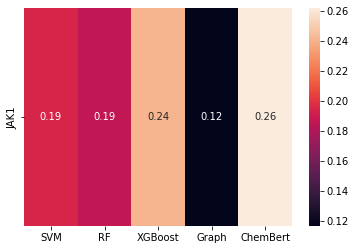

In [44]:
params = pd.DataFrame()
# -2.2434
params['SVM'] = [1.0379/(1.0379+0.9895+1.2842+0.6227+1.3942)]
params['RF'] = [0.9895/(1.0379+0.9895+1.2842+0.6227+1.3942)]
params['XGBoost'] = [1.2842/(1.0379+0.9895+1.2842+0.6227+1.3942)]
params_JAK1['Graph'] = [0.6227/(1.0379+0.9895+1.2842+0.6227+1.3942)]
params_JAK1['ChemBert'] = [1.3942/(1.0379+0.9895+1.2842+0.6227+1.3942)]
params_JAK1.index = ['JAK1']
# params_JAK1 = np.array([1.0379, 0.9895, 1.2842, 0.6227, 1.3942]).reshape(-1,1)

import seaborn as sns

ax = sns.heatmap(params_JAK1, annot=True)

In [ ]:
# JAK1
# Parameter containing:
# tensor([[1.0379, 0.9895, 1.2842, 0.6227, 1.3942]], requires_grad=True)
# Parameter containing:
# tensor([-2.2434], requires_grad=True)

# Parameter containing:
# tensor([[0.8725, 0.8156, 0.8013, 1.1736, 1.5972]], requires_grad=True)
# Parameter containing:
# tensor([-2.1325], requires_grad=True)

# JAK2
# Parameter containing:
# tensor([[1.1116, 0.8958, 0.7605, 1.3776, 1.7598]], requires_grad=True)
# Parameter containing:
# tensor([-2.9552], requires_grad=True)

# Parameter containing:
# tensor([[0.7218, 0.8260, 1.3243, 1.2601, 1.8034]], requires_grad=True)
# Parameter containing:
# tensor([-2.9857], requires_grad=True)

# JAK3
# Parameter containing:
# tensor([[0.7654, 1.1997, 0.3108, 1.2645, 1.5275]], requires_grad=True)
# Parameter containing:
# tensor([-2.5899], requires_grad=True)

# TYK2
# Parameter containing:
# tensor([[0.4161, 0.2859, 1.1439, 1.2353, 0.4284]], requires_grad=True)
# Parameter containing:
# tensor([-1.7482], requires_grad=True)

In [163]:
0.8725*0.981885318619119+0.8156+0.8013*0.9989202+1.1736*0.999644875526428+1.5972*0.99997889995575

5.243079221682321

In [71]:
torch.save(model, 'model/comodel_TYK2.pt')

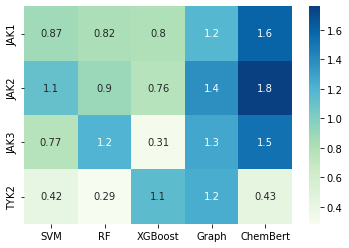

In [167]:
import matplotlib.cm as cm
params = np.array([[0.8725, 0.8156, 0.8013, 1.1736, 1.5972],\
          [1.1116, 0.8958, 0.7605, 1.3776, 1.7598],\
          [0.7654, 1.1997, 0.3108, 1.2645, 1.5275],\
          [0.4161, 0.2859, 1.1439, 1.2353, 0.4284]
         ])
bias = [-2.1325, -2.955, -2.5899, -1.7482]

params = params


params_df = pd.DataFrame()
# -2.2434
params_df['SVM'] = params[:,0]
params_df['RF'] = params[:,1]
params_df['XGBoost'] = params[:,2]
params_df['Graph'] = params[:,3]
params_df['ChemBert'] = params[:,4]
params_df.index = ['JAK1', 'JAK2', 'JAK3', 'TYK2']
# params_JAK1 = np.array([1.0379, 0.9895, 1.2842, 0.6227, 1.3942]).reshape(-1,1)

import seaborn as sns

ax = sns.heatmap(params_df, annot=True, cmap='GnBu')

In [222]:
enzymes = ['JAK1', 'JAK2', 'JAK3', 'TYK2']
for enzyme in enzymes:
    ind = enzymes.index(enzyme)
    data_path = 'data/' + enzyme + '_new.csv'
    data = pd.read_csv(data_path)
    y = data['Activity'].to_numpy()
    
    probs = data.iloc[:,3:].to_numpy()
    

    probs = torch.Tensor(probs)
    ys = torch.Tensor(y)
    import torch.utils.data as utils
    use_cuda = False
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    dataset = utils.TensorDataset(probs, ys)

    split = 0.8
    train_num = int(split*probs.size(0))
    test_num = probs.size(0) - train_num

    train_set, test_set = torch.utils.data.random_split(dataset, [train_num, test_num], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=test_num, shuffle=False)

    sigmoid = lambda x: 1/(1+np.exp(-x))

    for x, y in test_loader:
    #     model = torch.load('model/comodel_' + enzyme + '.pt')
    #     prob = model(x)
    #     print(sigmoid(params[3:4]@x.detach().numpy().T+bias[3]))
        print(x.size())
    prob = sigmoid(params[ind:(ind+1)]@x.detach().numpy().T+bias[ind])[0]
    y = y.detach().numpy()
    pred = get_preds(prob)

    evaluate(y, pred, prob)
    t, f = get_tpr_fpr(y, prob)
    save_tpr_fpr('comodel', enzyme, t, f)

torch.Size([1475, 5])
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.989  &  0.985  &          0.993  &     0.993  &0.978  &0.993 &0.999 &   0.970 &   1.000
torch.Size([2033, 5])
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.975  &  0.974  &          0.986  &     0.977  &0.971  &0.981 &0.996 &   0.943 &   0.998
torch.Size([1545, 5])
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.970  &  0.969  &          0.986  &     0.970  &0.969  &0.978 &0.993 &   0.930 &   0.997
torch.Size([485, 5])
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.988  &  0.985  &          0.987  &     0.994  &0.977  &0.990 &0.999 &   0.973 &   0.999


In [187]:
def get_preds(probabilities, threshold=0.5):
        return [1 if prob > threshold else 0 for prob in probabilities]


Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.988  &  0.985  &          0.987  &     0.994  &0.977  &0.990 &0.999 &   0.973 &   0.999


In [175]:
labels = y
probas = prob1
thre = 0.5
print(classification_report(labels, probas>thre))
print('\ttest acc = {}\tap = {}\tf1 = {}\troc = {}'.format(round(accuracy_score(labels, (probas>thre)*1)*100, 2), \
             round(average_precision_score(labels, probas)*100, 2), round(f1_score(labels, (probas>thre)*1)*100, 2), round(roc_auc_score(labels, probas)*100, 2)))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       176
         1.0       0.99      0.99      0.99       309

    accuracy                           0.99       485
   macro avg       0.99      0.99      0.99       485
weighted avg       0.99      0.99      0.99       485

	test acc = 98.76	ap = 99.92	f1 = 99.03	roc = 99.85


In [176]:
labels = y
probas = prob2
thre = 0.5
print(classification_report(labels, probas>thre))
print('\ttest acc = {}\tap = {}\tf1 = {}\troc = {}'.format(round(accuracy_score(labels, (probas>thre)*1)*100, 2), \
             round(average_precision_score(labels, probas)*100, 2), round(f1_score(labels, (probas>thre)*1)*100, 2), round(roc_auc_score(labels, probas)*100, 2)))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       176
         1.0       0.99      0.99      0.99       309

    accuracy                           0.99       485
   macro avg       0.99      0.99      0.99       485
weighted avg       0.99      0.99      0.99       485

	test acc = 98.76	ap = 99.92	f1 = 99.03	roc = 99.85


In [177]:
prob1-prob2[:,0]

array([-1.17670052e-05, -7.07720858e-07, -8.27197621e-07, -3.04042627e-07,
       -1.19797877e-05, -9.37099602e-07, -1.19602600e-05, -2.80498551e-07,
       -1.21199295e-05, -8.21453273e-06, -1.15330966e-05, -1.30589323e-05,
       -1.12080411e-05, -1.18632580e-05, -1.16990301e-05, -1.43981945e-05,
       -1.16255050e-05, -6.98460706e-07, -1.16046822e-05, -1.16318182e-05,
       -6.49588077e-07, -1.15427426e-05, -1.11558681e-05, -1.16969546e-05,
       -1.16682492e-05, -6.51131094e-07, -1.10703625e-05, -4.22773073e-07,
       -6.54377661e-07, -1.20257101e-05, -8.11977102e-06, -1.17145386e-05,
       -7.27440026e-07, -1.20009180e-05, -1.14713862e-05, -1.80989133e-06,
       -9.27560214e-07, -3.51428161e-07, -1.16791829e-05, -1.17378499e-05,
       -1.20405496e-05, -1.15974154e-05, -1.16097578e-05, -1.12892161e-05,
       -1.15825147e-05, -4.73409201e-07, -1.16092745e-05, -1.16149582e-05,
       -3.79913625e-07, -1.18281689e-05, -1.16357874e-05, -1.16200251e-05,
       -1.18630995e-05, -

In [115]:
print(pred.detach().numpy().tolist())

[[0.9551485180854797], [0.9394961595535278], [0.9560286998748779], [0.9560626149177551], [0.9561312794685364], [0.6630614399909973], [0.09734168648719788], [0.9480807185173035], [0.5528764724731445], [0.9079599380493164], [0.9553178548812866], [0.9544700384140015], [0.2112559974193573], [0.9512469172477722], [0.9326515793800354], [0.9489774703979492], [0.09869345277547836], [0.9558058381080627], [0.9552768468856812], [0.9562686085700989], [0.12520436942577362], [0.9516208171844482], [0.8747493028640747], [0.10243256390094757], [0.953078031539917], [0.10204314440488815], [0.9556024670600891], [0.9546800851821899], [0.9562672972679138], [0.9561081528663635], [0.9548352956771851], [0.954982578754425], [0.9518288969993591], [0.09846193343400955], [0.9490709900856018], [0.9552074670791626], [0.10668034851551056], [0.10968535393476486], [0.9553405046463013], [0.10698626190423965], [0.9314979910850525], [0.9559139013290405], [0.9470242261886597], [0.10473676770925522], [0.09652774780988693], 